In [1]:
# Import Packages and setup
import os
import logging

import numpy as np

import scarlet
import scarlet.display
import scarlet.constraints as sc

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# use a better colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='inferno')
matplotlib.rc('image', interpolation='none')

In [2]:
# Load the sample images
path = os.path.abspath(os.path.join(os.path.dirname(scarlet.__file__),".."))
data = np.load(os.path.join(path, "data/test_sim/data.npz"))
images = data["images"]
filters = data["filters"]

from astropy.table import Table as ApTable
catalog = ApTable.read(os.path.join(path, "data/test_sim/true_catalog.fits"))
bg_rms = np.array([20]*len(images))

asinh = scarlet.display.Asinh(img=images, Q=50)

In [35]:
def trim_noise(flux, bg_rms, ratio=0.1):
    if len(flux.shape)==4:
        low_morph = np.all(flux<ratio*bg_rms[None,:,None,None], axis=1)
        low_flux = np.repeat(low_morph[:,None,:,:], 6, axis=1)
    else:
        low_morph = np.all(flux<ratio*bg_rms[:,None, None], axis=0)
        low_flux = np.repeat(low_morph[None,:,:], 6, axis=0)
    return low_morph, low_flux

def getTrueValues(catalog, filters, bg_rms, ratio=0.1):
    flux = np.array([[src["intensity_"+f] for f in filters] for src in catalog])
    sed = np.array(catalog["sed"])
    morph = flux[:,0]/sed[:,0,None,None]
    low_flux = np.all(flux<ratio*bg_rms[None,:,None,None], axis=1)
    low_morph, low_flux = trim_noise(flux, bg_rms, ratio)
    morph[low_morph]
    flux[low_flux] = 0
    result = {
        "sed": sed,
        "flux": flux,
        "morph": morph,
        "symmetry": calculate_symmetry(morph),
        #"blending": calculate_blending(morph)
    }
    return result

def get_correlation(v1, v2):
    _v1 = v1.flatten()
    _v2 = v2.flatten()
    if np.sum(_v1)==0 or np.sum(_v2)==0:
        return 0
    return _v1.dot(_v2)/(np.sqrt(_v1.dot(_v1))*np.sqrt(_v2.dot(_v2)))

def get_blending(truth):
    model = np.sum(truth["morph"],axis=0).flatten()
    blending = np.zeros((len(truth["morph"])))
    for m,_morph in enumerate(truth["morph"]):
        flat_morph = _morph.flatten()
        blending[m] = 1-flat_morph.dot(flat_morph)/flat_morph.dot(model)
    return blending

def calculate_symmetry(morph):
    config = scarlet.config.Config(refine_skip=1)
    symmetry = np.zeros((len(morph),))
    for m in range(len(morph)):
        _morph = morph[m]
        # Estimate the center of the object
        idx = np.argmax(_morph)
        coords = np.unravel_index(idx, _morph.shape)
        # Fit the single source with only a symmetry constraint
        sources = [scarlet.source.ExtendedSource(coords, _morph[None,:], np.array([1e-9,]), constraints=[sc.SoftSymmetryConstraint(sigma=1)])]
        sym_blend = scarlet.Blend(sources, _morph[None, :], config=config)
        sym_blend.fit(100)
        # Calculated the correlation between the symmetric model and the source
        _symmetry = get_correlation(sym_blend.get_model(m=0)[0], _morph)
        symmetry[m] = _symmetry
    return symmetry

def clip_models(models, morphs, bg_rms, ratio):
    assert len(models) == len(morphs)
    new_models = models.copy()
    new_morphs = morphs.copy()
    for m in range(len(models)):
        low_morph, low_flux = trim_noise(models[m], bg_rms, ratio)
        new_morphs[m][low_morph] = 0
        new_models[m][low_flux] = 0
    return new_morphs, new_models

def show_images(img, ax, title=None, norm=asinh, filter_indices=None):
    if filter_indices is None:
        filter_indices = [3,2,1]
    rgb = scarlet.display.img_to_rgb(img, filter_indices=filter_indices, norm=norm)
    ax.imshow(rgb)
    if title is not None:
        ax.set_title(title)

def get_all_correlations(morphs, true_morph):
    correlations = np.zeros((len(morphs),))
    for m, morph in enumerate(morphs):
        correlations[m] = get_correlation(morph, true_morph[m])
    return correlations

def load_all_models(blend, ratio=0, truth=None):
    # Load all the models and morphologies for the blend
    models = blend.get_model(combine=False, flat=False)
    # All of the bands have the same intensity/morphology
    morphs = blend.get_model(combine=False, flat=False, use_sed=False)
    morphs = morphs[:,0,:,:]
    if ratio > 0:
        morphs, models = clip_models(models, morphs, bg_rms, ratio)
    if truth != None:
        correlations = get_all_correlations(morphs, truth["morph"])
    else:
        correlations = None
    return models, morphs, correlations

def compare_sources(*blends, images, truth, subset=None, show_sed=False,
                    show_truth=True, titles=None, ratio=0.5):
    """Display the data and model for all sources in multiple blends
    
    This convenience function is used to compare all (or a subset) of
    the sources and (optionally) their SED's deblended using different parameters.
    It is assumed that all sets of `sources` in `blends` have the same
    number of objects
    """
    if subset is None:
        # Show all sources in the blend
        subset = range(len(blends[0].sources))
    n_blends = len(blends)
    n_sources = len(blends[0].sources)
    if titles is None:
        titles = ["Model {0}".format(n) for n in range(n_sources)]
    # Extract the flux and morphologies and clip (if necessary)
    true_flux = truth["flux"]
    true_morph = truth["morph"]
    if ratio > 0:
        true_morph, true_flux = clip_models(true_flux, true_morph, bg_rms, ratio)

    all_models = []
    all_morphs = []
    all_correlations = []
    all_residuals = []
    for blend in blends:
        models, morphs, correlations = load_all_models(blend, ratio, truth=truth)
        all_models.append(models)
        all_morphs.append(morphs)
        all_correlations.append(correlations)

    # Configure the figure
    figsize = [3+3*n_blends,6]
    columns = 1 + n_blends
    # Calculate the number of columns needed and shape of the figure
    if show_truth:
        figsize[0] += 3
        columns += 1
    for m in subset:
        src = blends[0].sources[m]
        # Build the figure
        fig = plt.figure(figsize=figsize, frameon=True)
        ax = [fig.add_subplot(2,columns,n+1) for n in range(2*columns)]
        # Display the original image
        show_images(images[src.bb], ax[0], "Data")
        show_images((images-true_flux[m])[src.bb], ax[columns])
        # Display the source in all of the blends
        for b, blend in enumerate(blends):
            show_images(all_models[b][m][src.bb], ax[b+1], titles[b])
            c = all_correlations[b][m]
            show_images((all_models[b][m]-true_flux[m])[src.bb], ax[b+1+columns], title=r"$\xi$={0:.4f}".format(c))
        # Display the true source
        if show_truth:
            show_images(true_flux[m][src.bb], ax[b+2], "Truth")
            show_images(np.zeros(true_flux[m][src.bb].shape), ax[b+2+columns])

        if show_sed:
            for sed in src.sed:
                ax[-1].plot(sed)
            ax[-1].set_title("SED")
            ax[-1].set_xlabel("Band")
            ax[-1].set_ylabel("Intensity")
        # Mark the current source in the image
        y,x = src.center
        ax[0].plot(x-src.bb[2].start, y-src.bb[1].start, 'wx', mew=2)
        plt.tight_layout()
        plt.show()

In [26]:
sources = [scarlet.source.ExtendedSource((src['y'],src['x']), images, bg_rms, constraints=[sc.SoftSymmetryConstraint(sigma=.9) & sc.PositivityConstraint() & sc.DirectMonotonicityConstraint()]) for src in catalog]
blend1 = scarlet.Blend(sources, images, bg_rms=bg_rms)
blend1.fit(200)

In [27]:
sources = [scarlet.source.ExtendedSource((src['y'],src['x']), images, bg_rms, constraints=[sc.SmoothSymmetryConstraint(sigma=.9) & sc.PositivityConstraint() & sc.DirectMonotonicityConstraint()]) for src in catalog]
blend2 = scarlet.Blend(sources, images, bg_rms=bg_rms)
blend2.fit(200)

In [28]:
sources = [scarlet.source.ExtendedSource((src['y'],src['x']), images, bg_rms) for src in catalog]
blend3 = scarlet.Blend(sources, images, bg_rms=bg_rms)
blend3.fit(200)

In [29]:
sources = [scarlet.source.ExtendedSource((src['y'],src['x']), images, bg_rms, constraints=[sc.PositivityConstraint() & sc.DirectMonotonicityConstraint()]) for src in catalog]
blend4 = scarlet.Blend(sources, images, bg_rms=bg_rms)
blend4.fit(200)

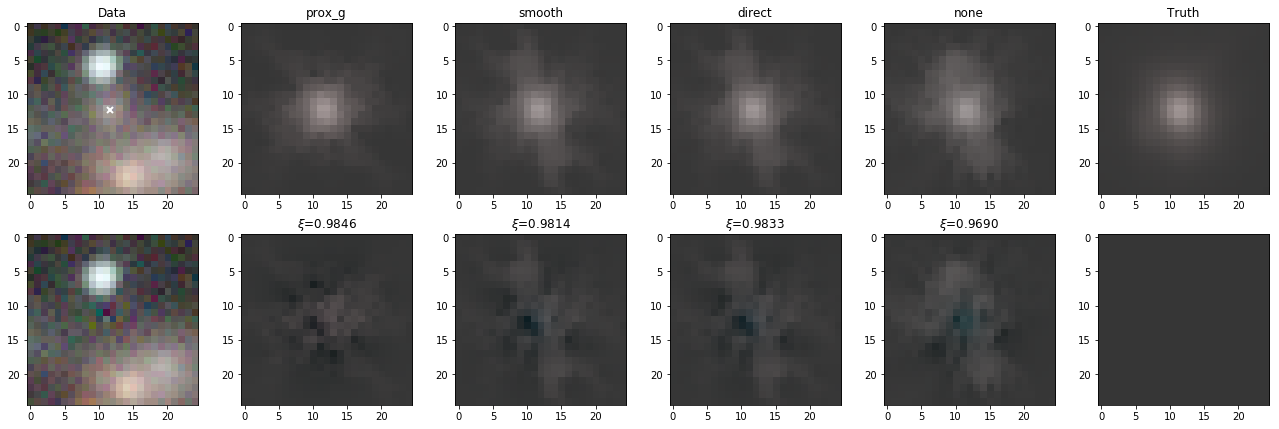

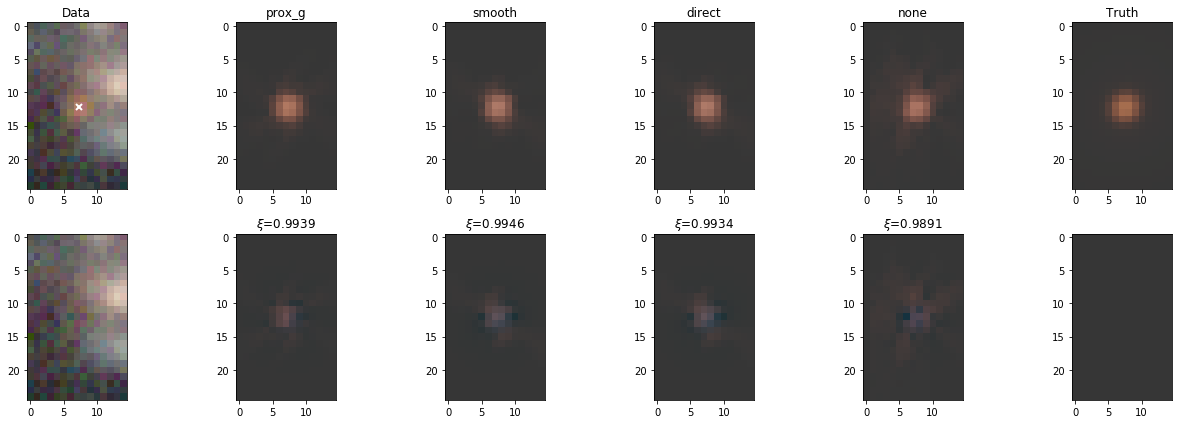

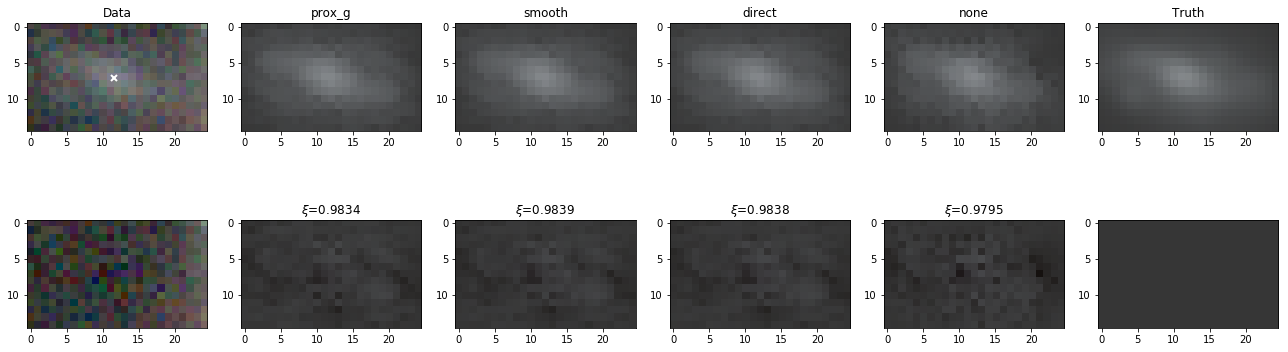

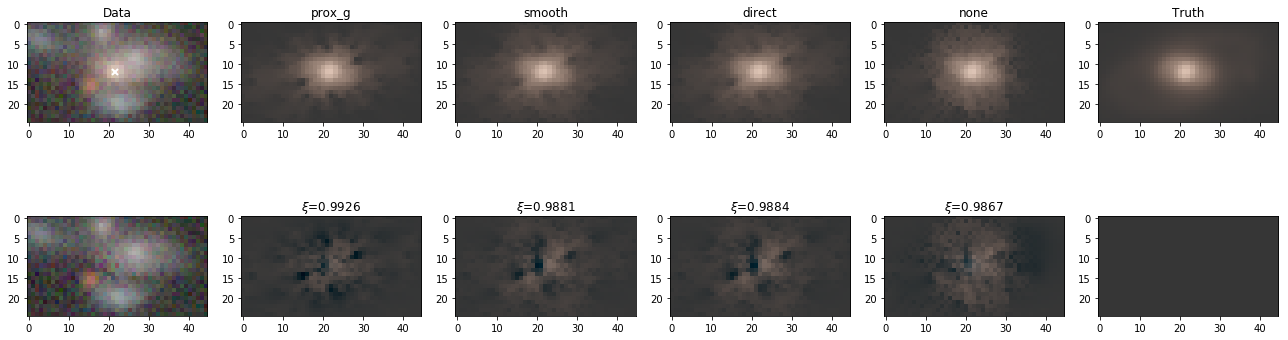

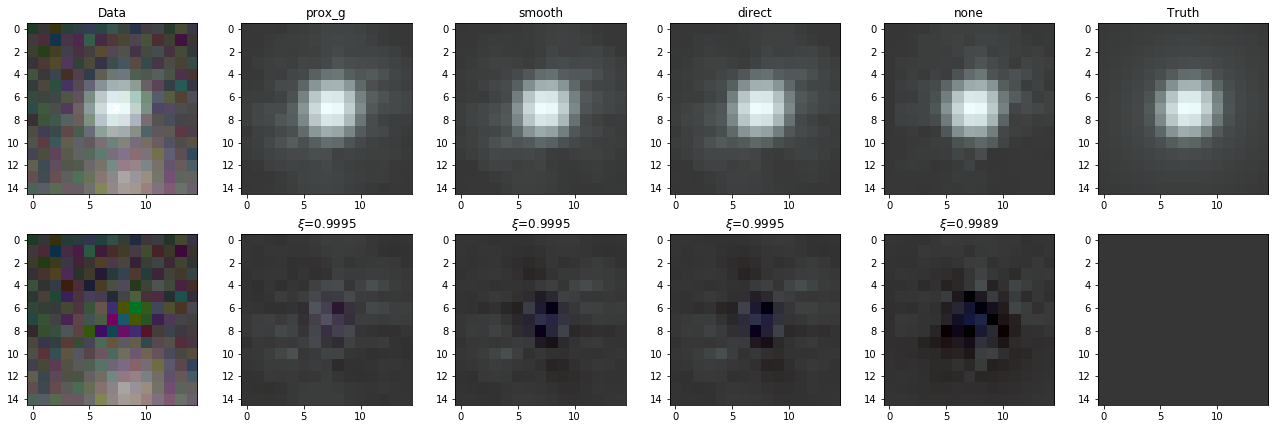

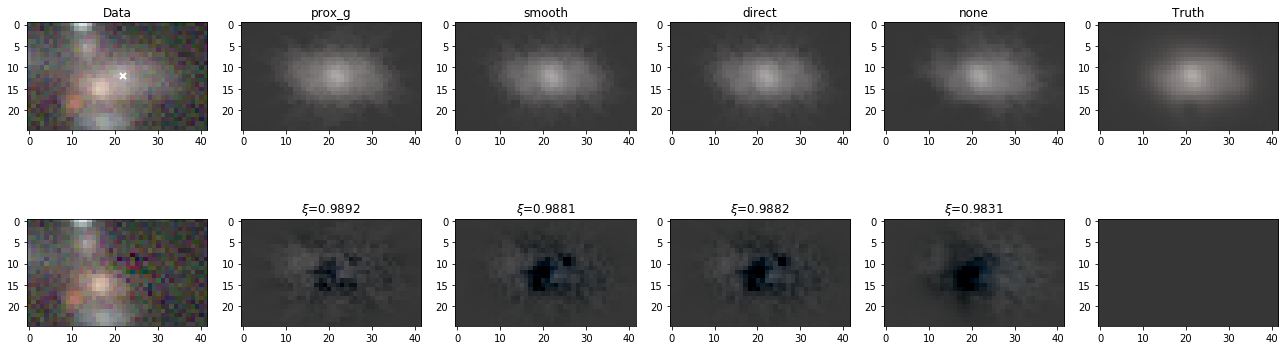

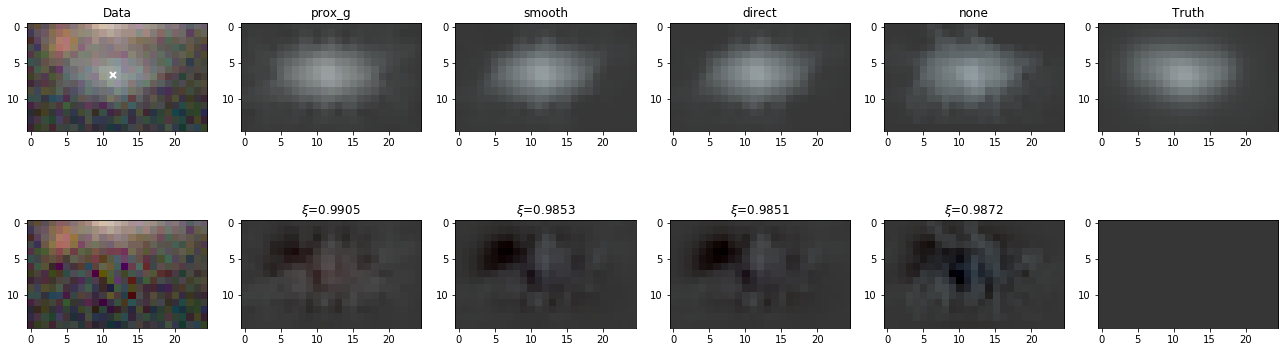

In [41]:
truth = getTrueValues(catalog, filters, bg_rms, 0)
compare_sources(blend3, blend2, blend1, blend4, images=images, truth=truth, show_sed=False, titles=["prox_g", "smooth", "direct", "none"], ratio=0)

In [37]:
from collections import OrderedDict
import time
sigmas = [1, .8, .5, .3, .1, .05, .01, .001, .0001, 0]
blends = []
for sigma in sigmas:
    if sigma > 0:
        sources = [scarlet.source.ExtendedSource((src['y'],src['x']), images, bg_rms, constraints=[sc.SmoothSymmetryConstraint(sigma=sigma) & sc.PositivityConstraint() & sc.DirectMonotonicityConstraint()]) for src in catalog]
    else:
        sources = [scarlet.source.ExtendedSource((src['y'],src['x']), images, bg_rms, constraints=[sc.PositivityConstraint() & sc.DirectMonotonicityConstraint()]) for src in catalog]
    _blend = scarlet.Blend(sources, images, bg_rms=bg_rms)
    t0 = time.time()
    _blend.fit(100, e_rel=1e-10)
    t1 = time.time()
    blends.append(_blend)
    print(sigma, t1-t0, _blend.it)

1 0.9456560611724854 100


0.8 0.915687084197998 100


0.5 0.9393789768218994 100


0.3 0.9113678932189941 100


0.1 0.9382867813110352 100


0.05 0.9549460411071777 100


0.01 0.940485954284668 100


0.001 0.9498169422149658 100


0.0001 0.9176650047302246 100


0 0.9206757545471191 100


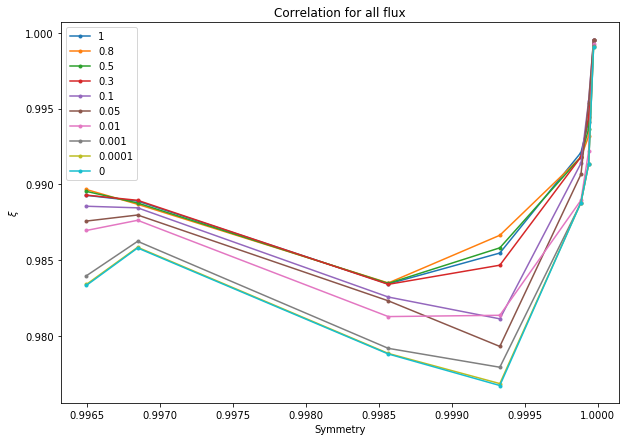

In [53]:
ratio = 0
idx = np.argsort(truth["symmetry"])
fig = plt.figure(figsize=(10,7))
mean_correlations = []
std_correlations = []
for n, blend in enumerate(blends):
    models, morphs, correlations = load_all_models(blend, ratio=ratio, truth=truth)
    plt.plot(truth["symmetry"][idx], correlations[idx], '.-', label=sigmas[n])
    plt.title("Correlation for all flux")
    plt.xlabel("Symmetry")
    plt.ylabel(r"$\xi$")
    mean_correlations.append(np.mean(correlations))
    std_correlations.append(np.std(correlations))
plt.legend()
plt.show()

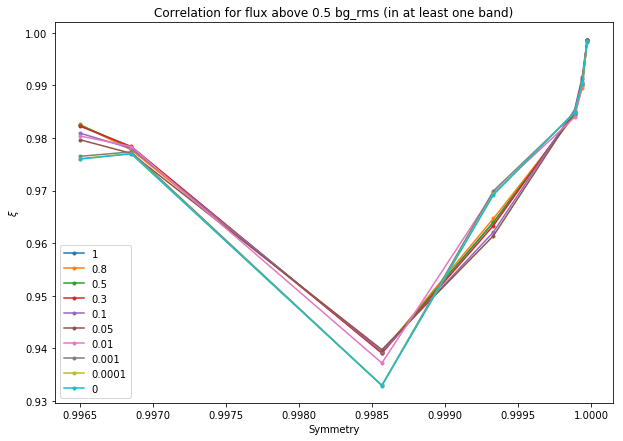

In [52]:
ratio = .5
_truth = getTrueValues(catalog, filters, bg_rms, ratio)
idx = np.argsort(truth["symmetry"])
fig = plt.figure(figsize=(10,7))
for n, blend in enumerate(blends):
    models, morphs, correlations = load_all_models(blend, ratio=ratio, truth=truth)
    plt.plot(truth["symmetry"][idx], correlations[idx], '.-', label=sigmas[n])
    plt.title("Correlation for flux above {0} bg_rms (in at least one band)".format(ratio))
    plt.xlabel("Symmetry")
    plt.ylabel(r"$\xi$")
plt.legend()
plt.show()

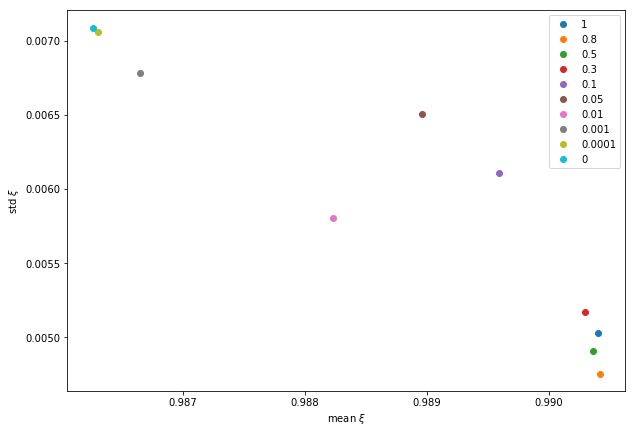

In [62]:
fig = plt.figure(figsize=(10,7))
for n,sigma in enumerate(sigmas):
    plt.plot(mean_correlations[n], std_correlations[n], 'o', label=sigma)
plt.xlabel(r"mean $\xi$")
plt.ylabel(r"std $\xi$")
plt.legend()
plt.show()

In [63]:
blends = []
for sigma in sigmas:
    if sigma > 0:
        sources = [scarlet.source.ExtendedSource((src['y'],src['x']), images, bg_rms, constraints=[sc.SoftSymmetryConstraint(sigma=sigma) & sc.PositivityConstraint() & sc.DirectMonotonicityConstraint()]) for src in catalog]
    else:
        sources = [scarlet.source.ExtendedSource((src['y'],src['x']), images, bg_rms, constraints=[sc.PositivityConstraint() & sc.DirectMonotonicityConstraint()]) for src in catalog]
    _blend = scarlet.Blend(sources, images, bg_rms=bg_rms)
    t0 = time.time()
    _blend.fit(100, e_rel=1e-10)
    t1 = time.time()
    blends.append(_blend)
    print(sigma, t1-t0, _blend.it)

1 1.0086090564727783 100


0.8 1.0355172157287598 100


0.5 1.0550339221954346 100


0.3 1.0955698490142822 100


0.1 1.0016450881958008 100


0.05 0.9303078651428223 100


0.01 1.019991159439087 100


0.001 1.0130057334899902 100


0.0001 0.9977540969848633 100


0 0.9716439247131348 100


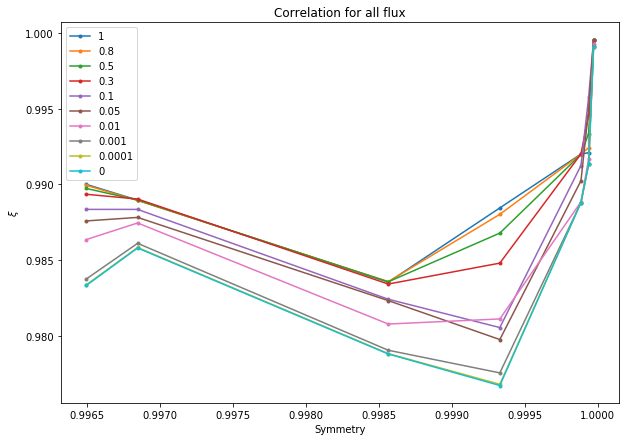

In [64]:
ratio = 0
idx = np.argsort(truth["symmetry"])
fig = plt.figure(figsize=(10,7))
mean_correlations = []
std_correlations = []
for n, blend in enumerate(blends):
    models, morphs, correlations = load_all_models(blend, ratio=ratio, truth=truth)
    plt.plot(truth["symmetry"][idx], correlations[idx], '.-', label=sigmas[n])
    plt.title("Correlation for all flux")
    plt.xlabel("Symmetry")
    plt.ylabel(r"$\xi$")
    mean_correlations.append(np.mean(correlations))
    std_correlations.append(np.std(correlations))
plt.legend()
plt.show()

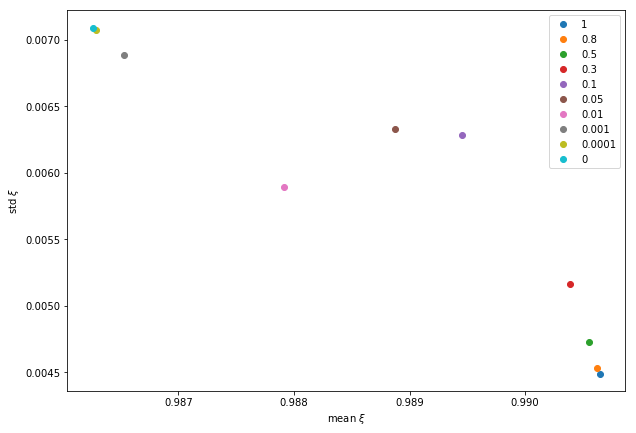

In [65]:
fig = plt.figure(figsize=(10,7))
for n,sigma in enumerate(sigmas):
    plt.plot(mean_correlations[n], std_correlations[n], 'o', label=sigma)
plt.xlabel(r"mean $\xi$")
plt.ylabel(r"std $\xi$")
plt.legend()
plt.show()